In [ ]:
import numpy as np
N = 64;  coeff = 1.e-9;  Breg = 10000.;  Nreg = 100.

"""
Make sure N and coeffs are same as mine
Coeff needs to change U,V smaller to fit in grid
In original code, U,Vs are power of 10^{10} and this scalling pushes them into -10 to 10
"""

# reading data
list_of_strings = []
with open('data', 'r') as f:
  for line in f:
    list_of_strings.append(line)
Na = len(list_of_strings) #-1 For mine because there is extra line 
UVa, sigma = np.zeros((2*Na, 2)), np.zeros(2*Na)
Oa = np.zeros(2*Na).astype(complex)
for a in range(Na):
  current_string = (list_of_strings[-1]).split(" ") # Split on commas
  list_of_strings.pop()
  UVa[a, 0], UVa[a, 1] = float(current_string[3]), float(current_string[4])
  Oa[a] = float(current_string[5])*np.exp(1j*float(current_string[6])*np.pi/180.)
  sigma[a] = float(current_string[7])
  UVa[a + Na], Oa[a + Na], sigma[a + Na] = -UVa[a], np.conj(Oa[a]), sigma[a]
del list_of_strings, current_string

# local cubic interpolation
def cubf1(x, y):                              #      8  11
  cf1 = (1. + x - x*x)*(1. + 2.*y)*(1. - y)   #   8  2  3  10
  cf2 = (1. + y - y*y)*(1. + 2.*x)*(1. - x)   #   4  0  1  6
  return 0.5*(cf1 + cf2)*(1. - x)*(1. - y)    #      5  7
def cubf2(x, y):  return -0.5*x*(1. - x)*(1. - x)*(1. + 2.*y)*(1. - y)*(1. - y)
IND = np.array([[-2, -2], [-1, -2], [-2, -1], [-1, -1], [-3, -2], [-2, -3], \
  [0, -2], [-1, -3], [-3, -1], [-2, 0], [0, -1], [-1, 0]]).astype(int)
def cubfun12(x, y):  return np.array([cubf1(x, y), cubf1(1. - x, y), \
    cubf1(x, 1. - y), cubf1(1. - x, 1. - y), cubf2(x, y), cubf2(y, x), \
    cubf2(1. - x, y), cubf2(y, 1. - x), cubf2(x, 1. - y), cubf2(1. - y, x), \
    cubf2(1. - x, 1. - y), cubf2(1. - y, 1. - x)])

"""
Calculate DO
Compare G = -2DO
"""

# computing DO, the dirty image from observations
DOuv = np.zeros((N, N)).astype(complex)
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = Oa[a] / sigma[a]**2, cubfun12(x, y)
  for c in range(12):  DOuv[m1 + IND[c, 0], m2 + IND[c, 1]] += C*CUBFUN[c]
DO = N*np.real(np.fft.ifft2(DOuv))
del DOuv

# computing DK, the dirty kernel
DK49, DK = np.zeros((N, N, 7, 7)), []
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = 1. / sigma[a]**2, cubfun12(x, y)
  for c in range(12):
    for cp in range(12):
      DK49[m1 + IND[c, 0], m2 + IND[c, 1], 3 + IND[cp, 0] - IND[c, 0], \
           3 + IND[cp, 1] - IND[c, 1]] += CUBFUN[c]*CUBFUN[cp]*C
for u in range(N):
  for v in range(N):
    for du in range(7):
      for dv in range(7):
        if (DK49[u, v, du, dv] != 0.):
          DK.append([u, v, ((u + du) % N) - 3, ((v + dv) % N) - 3, \
            DK49[u, v, du, dv]])
del DK49, IND, CUBFUN

# computing DI, the dirtying of the image I
I12, Iuv = np.zeros((2, N, N)), np.zeros((N, N)).astype(complex)
DI, DIuv = np.zeros((N, N)), np.zeros((N, N)).astype(complex)
def calc_DI():
  global Iuv, DI, DIuv
  Iuv, DIuv = np.fft.fft2(I), np.zeros((N, N)).astype(complex)
  for q in DK:  DIuv[q[0], q[1]] += q[4]*Iuv[q[2], q[3]]
  DI = np.real(np.fft.ifft2(DIuv))
  return

# computing G, the gradient of the loss function
def neighbor(Iat, Inear):  return np.sign(Iat - Inear)
def calc_G():
  global G
  calc_DI()
  G = 2.*(DI - DO)
#  G = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if (I[i, j] < 0.):  G[i, j] -= Breg
      if (I[i, j] > 0.):  G[i, j] += Nreg
#      G[i, j] += Breg*neighbor(I[i, j], 0.)
#      G[i, j] += Nreg*neighbor(I[i, j], I[i - 1, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, j - 1])
#      G[i, j] += Nreg*neighbor(I[i, j], I[(i + 1) % N, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, (j + 1) % N])
  return

I, dt = (0.*DO), 0.00001
for it in range(4000):
#  print(it)
  calc_G()
  I -= dt*G

#calc_DI()
for i in range(N):
  for j in range(N):
#    print(I[i, j], ' ', end='')
    print(DI[i, j] - DO[i, j], ' ', end='')
  print('')


In [20]:
import numpy as np
N = 80;  coeff = 1.5e-9;  Breg = 10000.;  Nreg = 100.

"""
Make sure N and coeffs are same as mine
Coeff needs to change U,V smaller to fit in grid
In original code, U,Vs are power of 10^{10} and this scalling pushes them into -10 to 10
"""

# reading data
list_of_strings = []
with open('./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv', 'r') as f:
  for line in f:
    list_of_strings.append(line)
list_of_strings.pop(0)
Na = len(list_of_strings) #-1 For mine because there is extra line 
print(len(list_of_strings))
UVa, sigma = np.zeros((2*Na, 2)), np.zeros(2*Na)
Oa = np.zeros(2*Na).astype(complex)
for a in range(Na):
  current_string = (list_of_strings[-1]).split(",") # Split on commas
  list_of_strings.pop()
  UVa[a, 0], UVa[a, 1] = float(current_string[3]), float(current_string[4])
  Oa[a] = float(current_string[5])*np.exp(1j*float(current_string[6])*np.pi/180.)
  sigma[a] = float(current_string[7])
  UVa[a + Na], Oa[a + Na], sigma[a + Na] = -UVa[a], np.conj(Oa[a]), sigma[a]
del list_of_strings, current_string

# local cubic interpolation
def cubf1(x, y):                              #      8  11
  cf1 = (1. + x - x*x)*(1. + 2.*y)*(1. - y)   #   8  2  3  10
  cf2 = (1. + y - y*y)*(1. + 2.*x)*(1. - x)   #   4  0  1  6
  return 0.5*(cf1 + cf2)*(1. - x)*(1. - y)    #      5  7
def cubf2(x, y):  return -0.5*x*(1. - x)*(1. - x)*(1. + 2.*y)*(1. - y)*(1. - y)
IND = np.array([[-2, -2], [-1, -2], [-2, -1], [-1, -1], [-3, -2], [-2, -3], \
  [0, -2], [-1, -3], [-3, -1], [-2, 0], [0, -1], [-1, 0]]).astype(int)
def cubfun12(x, y):  return np.array([cubf1(x, y), cubf1(1. - x, y), \
    cubf1(x, 1. - y), cubf1(1. - x, 1. - y), cubf2(x, y), cubf2(y, x), \
    cubf2(1. - x, y), cubf2(y, 1. - x), cubf2(x, 1. - y), cubf2(1. - y, x), \
    cubf2(1. - x, 1. - y), cubf2(1. - y, 1. - x)])

"""
Calculate DO
Compare G = -2DO
"""

# computing DO, the dirty image from observations
DOuv = np.zeros((N, N)).astype(complex)
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = Oa[a] / sigma[a]**2, cubfun12(x, y)
  for c in range(12):  DOuv[m1 + IND[c, 0], m2 + IND[c, 1]] += C*CUBFUN[c]
DO = N*np.real(np.fft.ifft2(DOuv))
del DOuv

# computing DK, the dirty kernel
DK49, DK = np.zeros((N, N, 7, 7)), []
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = 1. / sigma[a]**2, cubfun12(x, y)
  for c in range(12):
    for cp in range(12):
      DK49[m1 + IND[c, 0], m2 + IND[c, 1], 3 + IND[cp, 0] - IND[c, 0], \
           3 + IND[cp, 1] - IND[c, 1]] += CUBFUN[c]*CUBFUN[cp]*C
for u in range(N):
  for v in range(N):
    for du in range(7):
      for dv in range(7):
        if (DK49[u, v, du, dv] != 0.):
          DK.append([u, v, ((u + du) % N) - 3, ((v + dv) % N) - 3, \
            DK49[u, v, du, dv]])
del DK49, IND, CUBFUN

# computing DI, the dirtying of the image I
I12, Iuv = np.zeros((2, N, N)), np.zeros((N, N)).astype(complex)
DI, DIuv = np.zeros((N, N)), np.zeros((N, N)).astype(complex)
def calc_DI():
  global Iuv, DI, DIuv
  Iuv, DIuv = np.fft.fft2(I), np.zeros((N, N)).astype(complex)
  for q in DK:  DIuv[q[0], q[1]] += q[4]*Iuv[q[2], q[3]]
  DI = np.real(np.fft.ifft2(DIuv))
  return

# computing G, the gradient of the loss function
def neighbor(Iat, Inear):  return np.sign(Iat - Inear)
def calc_G():
  global G
  calc_DI()
  G = 2.*(DI - DO)
#  G = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if (I[i, j] < 0.):  G[i, j] -= Breg
      if (I[i, j] > 0.):  G[i, j] += Nreg
#      G[i, j] += Breg*neighbor(I[i, j], 0.)
#      G[i, j] += Nreg*neighbor(I[i, j], I[i - 1, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, j - 1])
#      G[i, j] += Nreg*neighbor(I[i, j], I[(i + 1) % N, j])
#      G[i, j] += Nreg*neighbor(I[i, j], I[i, (j + 1) % N])
  return

I, dt = (0.*DO), 0.00001
#for it in range(4000):
#  print(it)
#  calc_G()
#  I -= dt*G

calc_DI()
for i in range(N):
  for j in range(N):
#    print(I[i, j], ' ', end='')
    print(DI[i, j], ' ', end='')
  print('')


6458
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

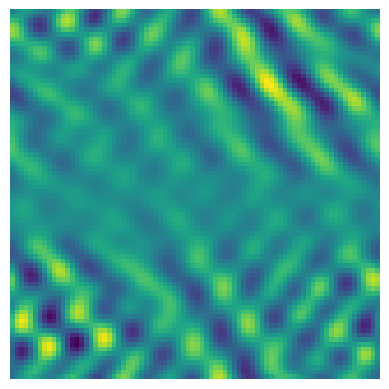

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(DO)
plt.axis('off')
plt.savefig("DO_2.png")

In [21]:
DO*-2

array([[-116646.46701886, -154067.28366657, -184195.63871951, ...,
        -124150.22554143,  -91932.26731236,  -90955.5333724 ],
       [-193352.29178963, -201615.47557008, -186977.07921745, ...,
        -167811.44099525, -163045.36609929, -175246.61693349],
       [-284671.89530133, -263623.26517283, -204849.62879024, ...,
        -212020.81661208, -243465.52260933, -273148.72344173],
       ...,
       [ -53949.78959703,  -59254.34629634, -102539.6132098 , ...,
        -215026.67993695, -149814.92336116,  -88488.01485705],
       [ -54144.07832109,  -95132.3982467 , -158822.33132351, ...,
        -141121.03097909,  -83103.53715131,  -49920.0259701 ],
       [ -70488.30137081, -122130.22503554, -181589.09045569, ...,
        -109552.68034749,  -60714.120173  ,  -46609.96696033]])

In [7]:
G1 = np.loadtxt("./gradient_2.txt", delimiter=",")
G2 = np.loadtxt("./gradient_forward.txt", delimiter=",")

In [22]:
np.max(np.abs(G1+2*DO))

2046084.1733988086

In [23]:
np.max(np.abs(G2+2*DO))

7609097.758413787